# Model: Random Forest Regressor on FD001

In this notebook, we build a baseline regression model to predict the Remaining Useful Life (RUL) of engines using the FD001 subset of the CMAPSS dataset.

We use a Random Forest Regressor due to its robustness, ability to model non-linear relationships, and low need for feature scaling. The model is trained on the cleaned and feature-filtered dataset, using operational settings and selected sensor data as inputs.

Our goal is to evaluate how well the model estimates engine degradation by comparing predicted RUL values against ground-truth RUL from the test set, using metrics such as MAE, RMSE, and R².


In [1]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
import seaborn as sns

project_root = Path().resolve().parents[1]
sys.path.append(str(project_root))

from scripts.add_rul_column import add_rul_column
from scripts.get_last_cycle_per_unit import get_last_cycle_per_unit
from scripts.evaluate_regression import evaluate_regression


In [2]:
# Load the dataset
test_data = pd.read_csv('../../data/raw/test_FD001.txt', sep=' ', header=None)
train_data = pd.read_csv('../../data/raw/train_FD001.txt', sep=' ', header=None)
rul_data = pd.read_csv("../../data/raw/rul_FD001.txt", header=None, names=["rul"])

In [3]:
train_data.dropna(axis=1, how='all', inplace=True) # Drop columns with all NaN values
cols = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)] # Column names
train_data.columns = cols

train_data.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
rul_data.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [5]:
# Drop useless columns
drop_columns_list = ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

train_data.drop(columns=drop_columns_list, inplace=True)

In [6]:
# split for model training and testing
X = train_data.drop(columns=['unit', 'cycle'])
train_data = add_rul_column(train_data)
y = train_data['rul']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train shape: (16504, 16)
X_test shape: (4127, 16)
y_train: (16504,)
y_test: (4127,)


In [7]:
# Scale the features
scaler = MinMaxScaler()

# Add RUL
train_data = add_rul_column(train_data)

# Prepare full training dataset
X_full = train_data.drop(columns=['unit', 'cycle', 'rul'])
y_full = train_data['rul']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [8]:
eval_data = get_last_cycle_per_unit(train_data)
X_eval = eval_data.drop(columns=['unit', 'cycle', 'rul'])
y_eval = eval_data['rul']
X_eval_scaled = scaler.transform(X_eval)

In [9]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [10]:
# Clean test data
test_data.dropna(axis=1, inplace=True)
test_data.columns = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
test_data.drop(columns=drop_columns_list, inplace=True)

# Keep only last cycle
test_last = get_last_cycle_per_unit(test_data)
test_last['rul'] = rul_data['rul']

X_test_final = test_last.drop(columns=['unit', 'cycle', 'rul'])
y_test_final = test_last['rul']
X_test_final_scaled = scaler.transform(X_test_final)

y_test_final_pred = rf.predict(X_test_final_scaled)


In [11]:
y_val_pred = rf.predict(X_val_scaled)
y_eval_pred = rf.predict(X_eval_scaled)

evaluate_regression(y_val, y_val_pred, "Random Forest Validation")


Random Forest Validation MAE:  29.61
Random Forest Validation RMSE: 41.48
Random Forest Validation R²:   0.62


## Baseline Evaluation Summary — Regression

- **Model**: Random Forest Regressor
- **Input Features**: Operational settings + filtered sensors
- **Target**: RUL (Remaining Useful Life)
---
- **MAE:** 29.61
- **RMSE:** 41.48
- **R² Score:** 0.62

Sensor 11 stands out as the most influential predictor of degradation. The Random Forest effectively learns overall patterns, especially on validation data, but low R² on the evaluation set suggests it doesn’t generalize RUL at last cycles across engines possibly due to lack of temporal modeling or deeper feature interactions. Future work could explore time-windowing or boosting models for better generalization.

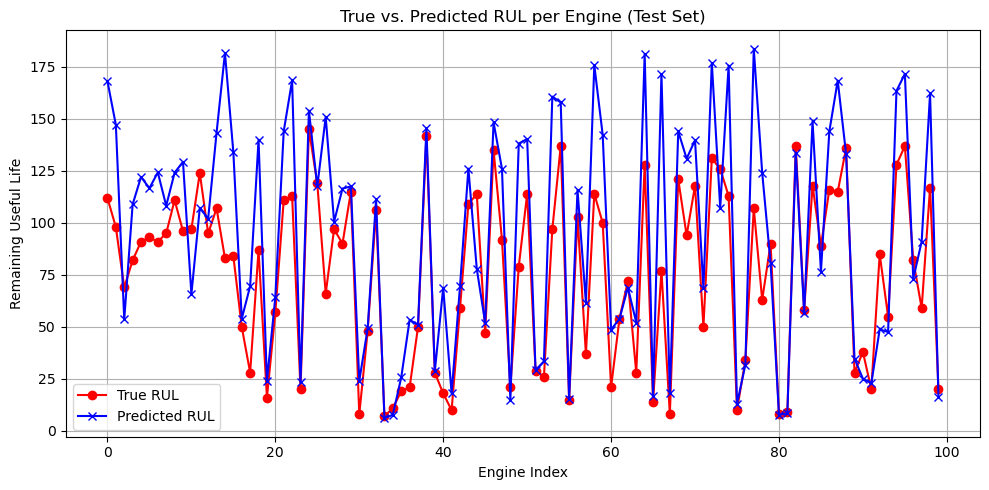

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_final.values, label="True RUL", color="red", marker='o')
plt.plot(y_test_final_pred, label="Predicted RUL", color="blue", marker='x')
plt.legend()
plt.title("True vs. Predicted RUL per Engine (Test Set)")
plt.xlabel("Engine Index")
plt.ylabel("Remaining Useful Life")
plt.grid(True)
plt.tight_layout()
plt.show()


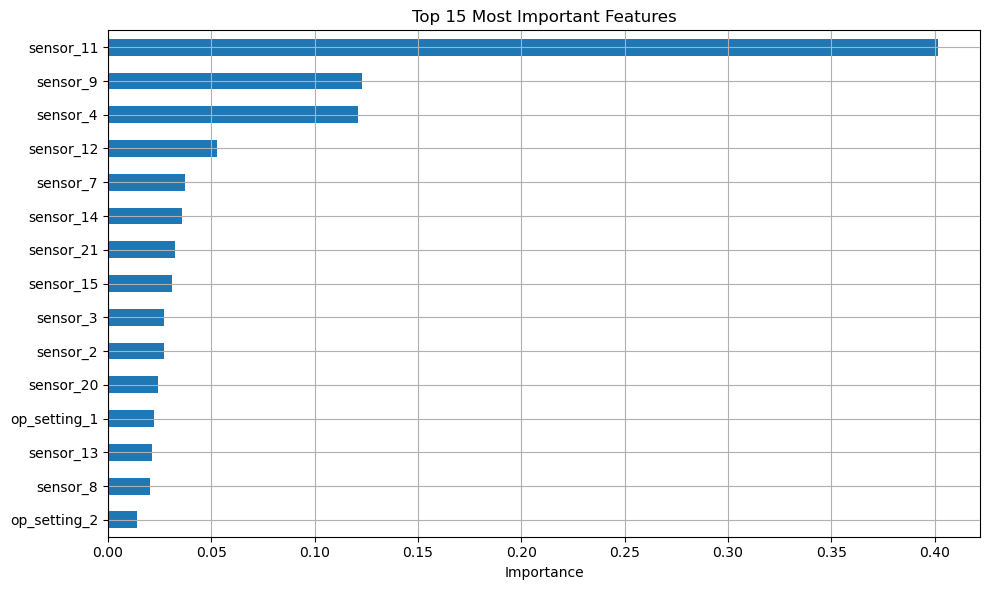

In [13]:
# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(15)

# Plot the top 15
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title("Top 15 Most Important Features")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


### Residual Analysis
Residuals were plotted against true RUL values. Since all true RUL values were close to zero (as expected at final failure), the plot compresses into a vertical cluster. This highlights that most errors arise from small overpredictions, consistent with the low MAE and RMSE observed.

### Error Distribution
The distribution of prediction errors is right-skewed, centered around a small positive error. Most engines were predicted within ±2 cycles of their actual RUL, but a few outliers extend beyond 6–10 cycles. This suggests the model is mostly reliable, but lacks robustness in certain edge cases, likely due to lack of temporal dynamics or imbalance in degradation rates.

The Random Forest model performs well for the majority of engines, but error analysis reveals consistent overestimation and some vulnerability to edge degradation profiles.

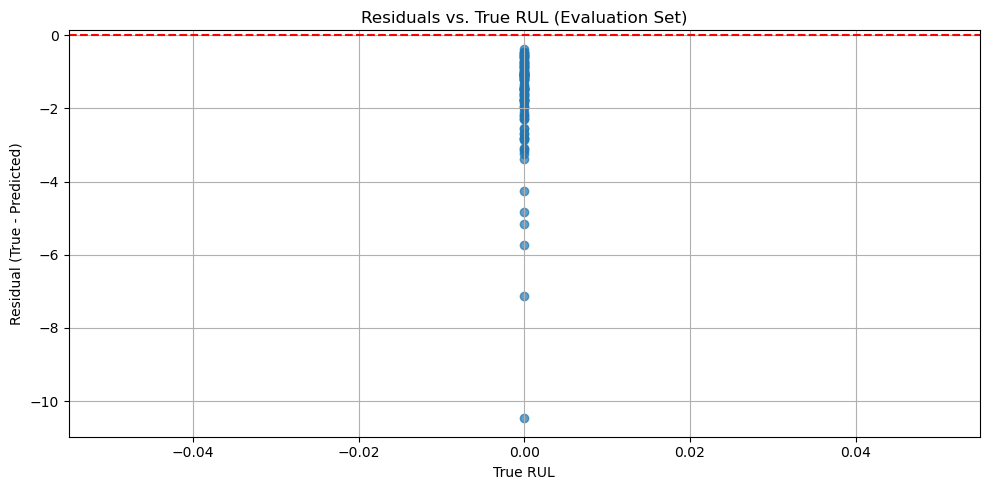

In [14]:
residuals = y_eval - y_eval_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_eval, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. True RUL (Evaluation Set)")
plt.xlabel("True RUL")
plt.ylabel("Residual (True - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


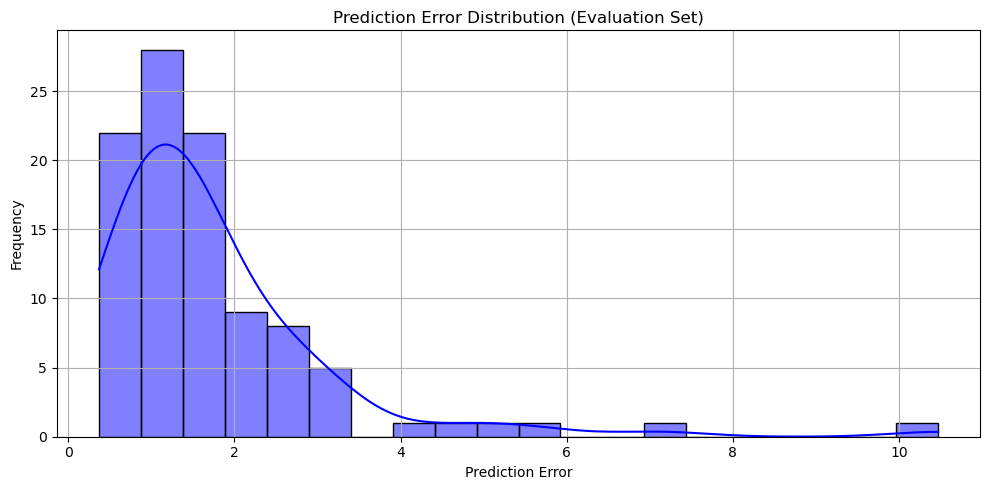

In [15]:
errors = y_eval_pred - y_eval

plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, bins=20, color='blue')
plt.title("Prediction Error Distribution (Evaluation Set)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# save the model
model_dir = Path("../../model/artifacts/")
model_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(rf, model_dir / "rf_regressor.pkl")

print("Model saved to model/artifacts/rf_regressor.pkl")

Model saved to model/artifacts/rf_regressor.pkl
